In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

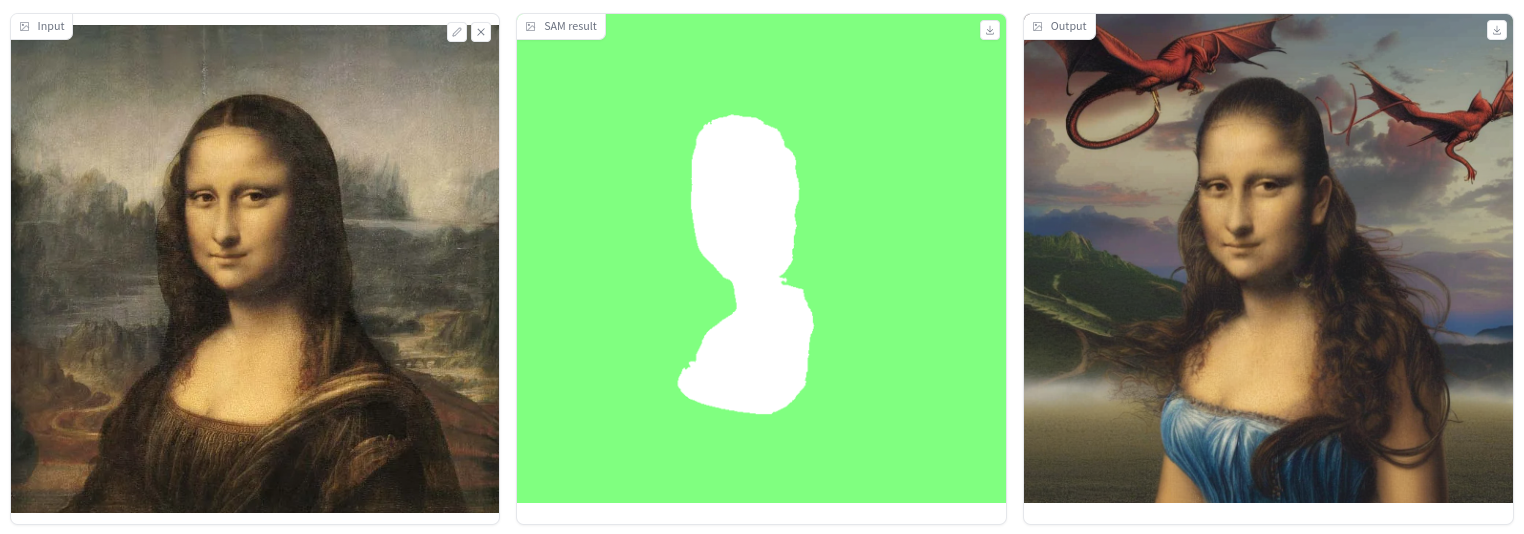

Let's start by importing what we need:

In [3]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
def mask_to_rgb(mask):
    
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent


def get_processed_inputs(image, input_points):
    
    inputs = processor(images=image, input_points=[input_points], return_tensors='pt').to("cuda")
    
    outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    best_mask = masks[0][0][outputs.iou_scores.argmax()] 
    return ~best_mask.cpu().numpy()

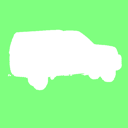

In [ ]:
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))

input_points = [[[150, 170], [300, 250]]]

mask = get_processed_inputs(raw_image, input_points)

Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

In [ ]:

pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    
    mask_image = Image.fromarray(input_mask)
    
    rand_gen = torch.manual_seed(seed)
    
    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=raw_image,
        mask_image=mask_image,
        generator=rand_gen,
        guidance_scale=cfgs
    ).images[0]
    
    return image

In [9]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

  0%|          | 0/49 [00:00<?, ?it/s]

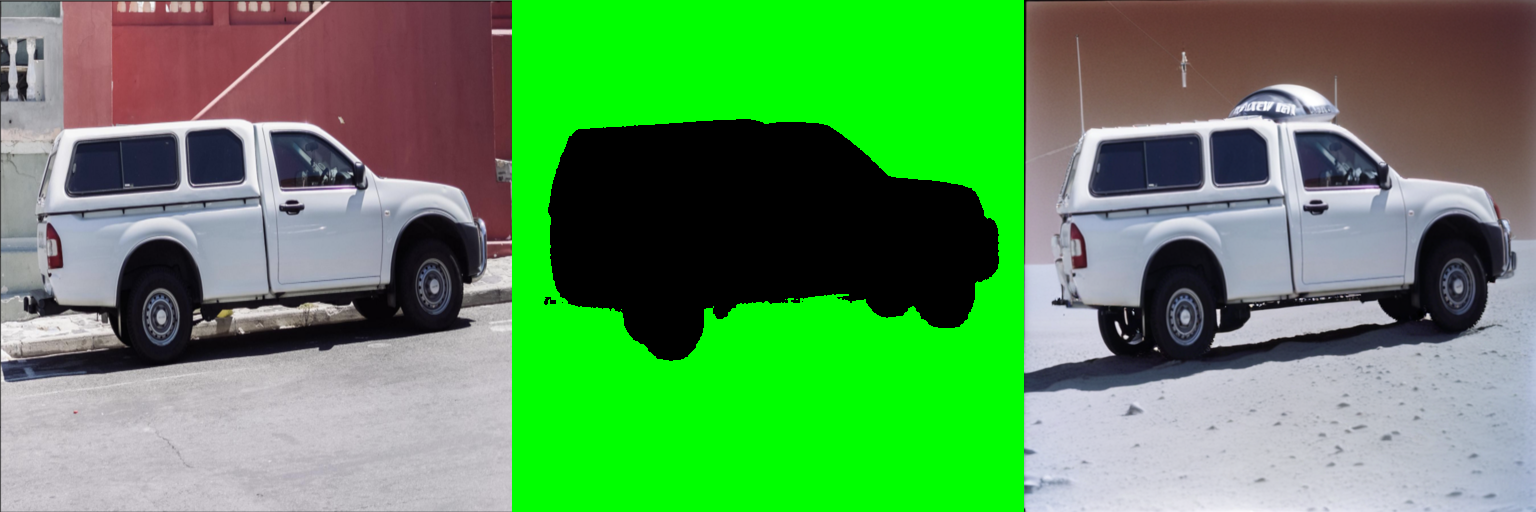

In [10]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

In [11]:
import app

In [ ]:
my_app = app.generate_app(get_processed_inputs, inpaint)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://a3a282694c85c9450d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/home/student/.local/lib/python3.10/site-packages/gradio/queueing.py", line 407, in call_prediction
    output = await route_utils.call_process_api(
  File "/home/student/.local/lib/python3.10/site-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/student/.local/lib/python3.10/site-packages/gradio/blocks.py", line 1550, in process_api
    result = await self.call_function(
  File "/home/student/.local/lib/python3.10/site-packages/gradio/blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/student/.local/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/home/student/.local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2144, in run_sync_in_worker_thread
    return await future
  File "/home/student/.local/lib/py

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
my_app.close()